In [1]:
from classes.Point import *
from pyproj import Proj
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation

### Load data

In [2]:
settlements = pd.concat(
    map(
        pd.read_csv,
        [
            'datasets/towns.csv',
            'datasets/cities.csv',
            'datasets/villages.csv'
        ]
    ),
    ignore_index = True
)

### Modify data

In [3]:
# Rename callret-3 column to population
settlements.rename(
    columns = { 'callret-3': 'population' },
    inplace = True
)

### Extend data

In [4]:
# Calculate radii of settlements
settlements['radius'] = settlements.apply(
    lambda row:
        math.sqrt(
            row['area'] / math.pi
        ),
    axis = 1
)

In [5]:
# Calculate densities of settlements
settlements['density'] = settlements.apply(
    lambda row:
        row['population'] / (row['area'] / 1000000),
    axis = 1
)

### Transform data

In [6]:
# Convert geographic settlements coords to x, y coords
projection = Proj(
    proj = 'utm',
    zone = 34,
    ellps = 'WGS84',
    preserve_units = False
)
x, y = projection(
    tuple(settlements.long),
    tuple(settlements.lat)
)
xs, ys = list(x), list(y)
xmin, ymin = min(xs), min(ys)
settlements['x'] = [ x - xmin for x in xs ]
settlements['y'] = [ y - ymin for y in ys ]

In [7]:
settlements.head()

,name,long,lat,population,area,radius,density,x,y
0,Barcs,17.4601,45.9601,10667,122900000.0,6254.621093,86.794142,94551.686596,22476.155936
1,Battonya,21.0167,46.2833,5960,145770000.0,6811.756903,40.886328,370132.118200,52291.852872
2,Beled,17.0968,47.4661,2686,26470000.0,2902.699207,101.473366,74712.467194,191117.163196
3,Belvárdgyula,18.4333,45.9667,397,17230000.0,2341.896526,23.041207,169983.061933,20317.899726
4,Budakalász,19.0460,47.6215,10660,15170000.0,2197.444191,702.702703,222025.590806,202849.524978


### Plot settlements

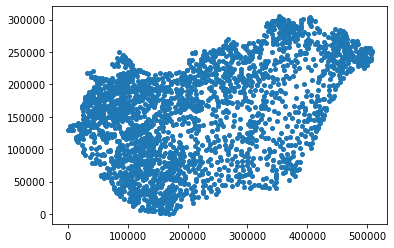

In [8]:
plt.plot(settlements.x, settlements.y, 'o', markersize = 4)
plt.show()

In [9]:
def random_status():
    return True if random.random() < 0.1 else False

def generatePeople(settlements):
    people = []
    for s in settlements:
        # settlement(name, long, lat, population, area, radius, density, x, y)
        settlement_name, center, radius, population = s[0], Point(s[7], s[8]), s[5], s[3]
        for _ in range(round(population/10000)):
            position = Point.randomPoint(radius, center)
            #covid_status = random_status()
            if settlement_name == "Budapest":
                covid_status = True
            else:
                covid_status = False
            people.append([settlement_name, position.x, position.y, covid_status])
    return people

def distance(x1,y1,x2,y2):
    d1=x1-x2
    d2=y1-y2
    out=math.sqrt(d1*d1+d2*d2)
    return(out)

people = pd.DataFrame(generatePeople(settlements.values), columns = ['city_name', 'x', 'y', 'infected'])
people.head()

,city_name,x,y,infected
0,Barcs,92860.332399,24710.351910,False
1,Battonya,372560.512303,56713.497875,False
2,Budakalász,221425.832663,201602.094553,False
3,Budakeszi,213632.026143,191402.490939,False
4,Budaörs,213501.877780,183108.205554,False


From the population of 718 (grey), 175 person is infected (red).


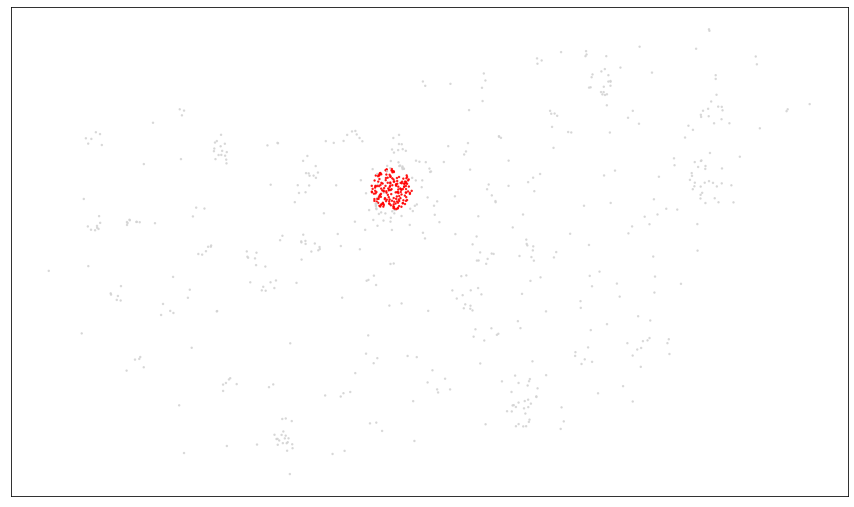

In [10]:
print("From the population of {} (grey), {} person is infected (red).".format(len(people),people.infected.sum()))

plt.figure(figsize=(15, 9))
plt.scatter(people.x, people.y, c=people.infected, cmap=ListedColormap(["lightgrey", "red"]), s=2, alpha=0.8)
plt.xticks([])
plt.yticks([])
plt.show()

# Move people



In [11]:
settlements_dict = settlements[["name", "population"]].values
settlements_dict[:, 1] /= sum(settlements_dict[:, 1])

# generating city moving probability distribution
city_names, city_probs  = list(settlements_dict[:, 0]), list(settlements_dict[:, 1])

In [12]:
def generate_city():
    global city_names, city_probs
    return np.random.choice(city_names, 1, p=city_probs)[0]

def change_position(city_name):
    global settlements
    # get the row belonging to the city_name from the settlements dataframe
    row = settlements.loc[settlements["name"] == city_name]
    # get radius, x, y values from row
    radius, x, y = row[['radius', 'x', 'y']].values[0]
    center = Point(x, y)
    position = Point.randomPoint(radius, center)
    return pd.Series([position.x, position.y], index =['x', 'y'])

# TODO: too long after move city, join the two datasets (people, settlements), and fill x, y and radius columns

people.head()

,city_name,x,y,infected
0,Barcs,92860.332399,24710.351910,False
1,Battonya,372560.512303,56713.497875,False
2,Budakalász,221425.832663,201602.094553,False
3,Budakeszi,213632.026143,191402.490939,False
4,Budaörs,213501.877780,183108.205554,False


In [13]:
print(people.loc[people['infected'] == True].size)

700


In [14]:
%%time
people_frames = []
# simulate 20 days
simulated_days = 20
# 10% move between cities, 20% move inside city
intercity_move_prob = 0.1
intracity_move_prob = 0.2

# move probability
move_prob = intercity_move_prob + intracity_move_prob
# number of people to move
move_num = round(people.shape[0] * move_prob)
# index to cut moving people (inside & outsite settlement)
cut = round(intercity_move_prob / move_prob * move_num)

for i in range(simulated_days):

    # random people to move
    moving = people.sample(move_num)

    # inside the settlement
    in_city = moving[:cut]
    for i in range(len(in_city)):
        in_city['x'].values[i], in_city['y'].values[i] = change_position(in_city['city_name'].values[i])

    # to another settlement
    out_city = moving[cut:]
    for i in range(len(out_city)):
        out_city['city_name'].values[i] = generate_city()

    people.update(in_city)
    people.update(out_city)

    people_frames.append(people.copy())

CPU times: user 2.67 s, sys: 9.58 ms, total: 2.68 s
Wall time: 2.69 s


# Animated plot

In [15]:
# Enable interactive plot
%matplotlib notebook

<IPython.core.display.Javascript object>


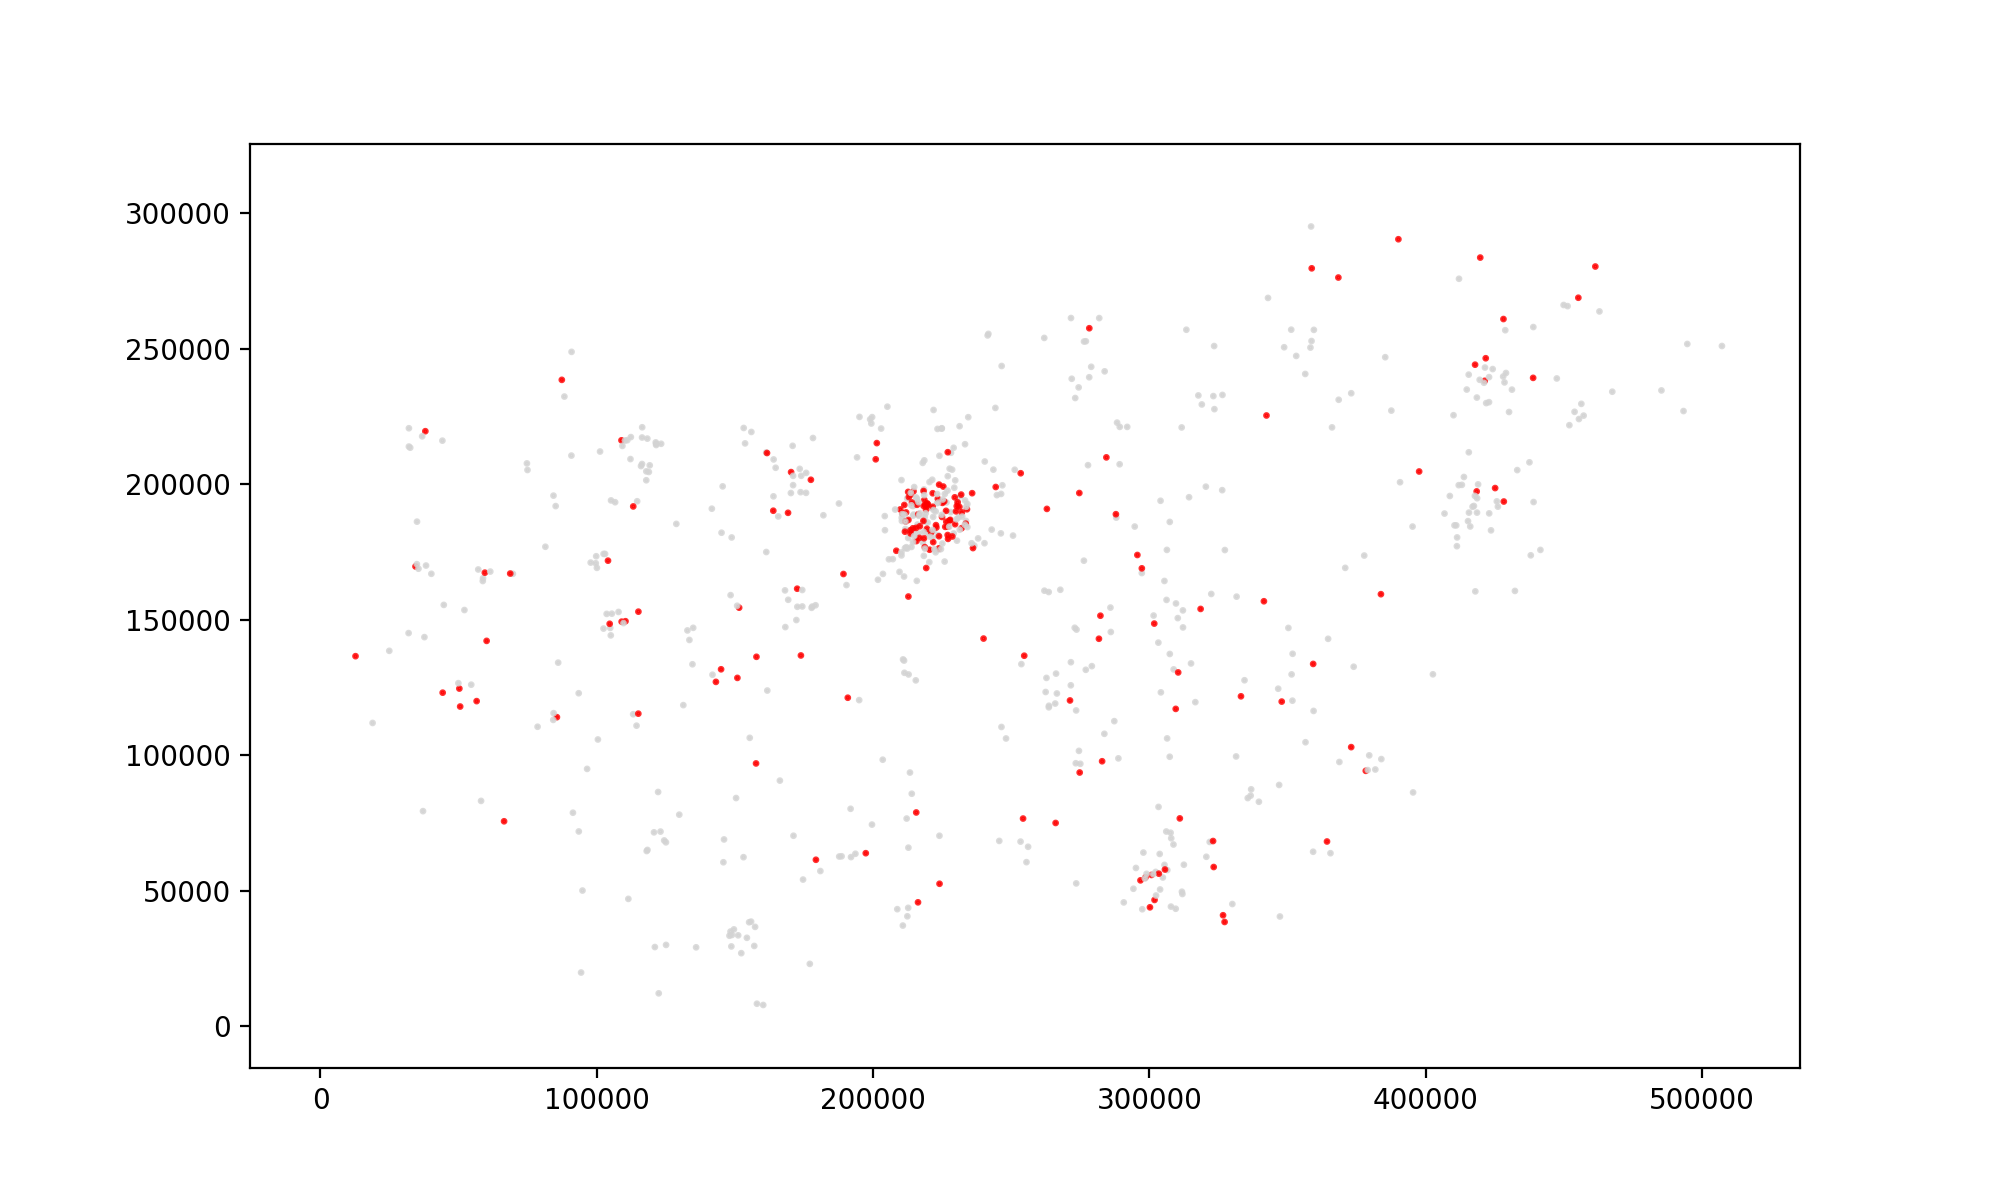

In [17]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()
ax.set_xlim(0, 520000), ax.set_xticks([])
ax.set_ylim(0, 310000), ax.set_yticks([])

# TODO: animation draws figures on top of each other, clear the older frames somehow
plot = plt.scatter([], [], c=[], cmap=ListedColormap(["lightgrey", "red"]), s=2, alpha=0.8)


def updatefig(*args):
    global people_frames
    fig.clear()
    plot = plt.scatter([people_frames[args[0]].x], people_frames[args[0]].y, c=people_frames[args[0]].infected, cmap=ListedColormap(["lightgrey", "red"]), s=2, alpha=0.8)
    plt.scatter([0, 510000], [0, 310000], s = 1, c = "white")
    return plot,

ani = FuncAnimation(fig, updatefig, frames=20, interval=1000/24, repeat=False)
plt.show()